In [1]:
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import tqdm

In [2]:
device = ("cuda" if torch.cuda.is_available else "cpu")
# device = "cpu"
print(f"Using {device}--->{torch.cuda.get_device_name()} device")

Using cuda--->NVIDIA GeForce GTX 1650 device


In [3]:
movies = pd.read_csv("dataset/movies.csv")
ratings = pd.read_csv("dataset/ratings.csv")
links = pd.read_csv("dataset/links.csv")

In [4]:
final = ratings.merge(movies, on="movieId").merge(links, on="movieId")
final

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,113277,949.0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,114369,807.0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,114814,629.0
...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller,4972582,381288.0
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller,4425200,324552.0
100833,610,168250,5.0,1494273047,Get Out (2017),Horror,5052448,419430.0
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,3315342,263115.0


In [5]:
### filtering dataframe
def dataset_creation(df: pd.DataFrame) -> pd.DataFrame:
    user_counts = final.groupby('userId')['userId'].size()
    user_with_50_ratings = user_counts[user_counts >= 50].index
    filtered_df = df[df['userId'].isin(user_with_50_ratings)]
    filtered_df = filtered_df.loc[:,["userId","movieId","rating","title","genres","imdbId"]]
    filtered_df.loc[:,"genres"] = filtered_df.loc[:,"genres"].apply(lambda x: x.split("|"))
    return filtered_df

filtered_df = dataset_creation(final)

In [6]:
filtered_df

,userId,movieId,rating,title,genres,imdbId
0,1,1,4.0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",114709
1,1,3,4.0,Grumpier Old Men (1995),"[Comedy, Romance]",113228
2,1,6,4.0,Heat (1995),"[Action, Crime, Thriller]",113277
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",114369
4,1,50,5.0,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",114814
...,...,...,...,...,...,...
100831,610,166534,4.0,Split (2017),"[Drama, Horror, Thriller]",4972582
100832,610,168248,5.0,John Wick: Chapter Two (2017),"[Action, Crime, Thriller]",4425200
100833,610,168250,5.0,Get Out (2017),[Horror],5052448
100834,610,168252,5.0,Logan (2017),"[Action, Sci-Fi]",3315342


In [7]:
useful_df = final.loc[:, ["userId", "movieId", "rating","title", "imdbId"]]
# useful_df.drop_duplicates(subset=["userId", "movieId", "rating"], keep='first')
useful_df

,userId,movieId,rating,title,imdbId
0,1,1,4.0,Toy Story (1995),114709
1,1,3,4.0,Grumpier Old Men (1995),113228
2,1,6,4.0,Heat (1995),113277
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),114369
4,1,50,5.0,"Usual Suspects, The (1995)",114814
...,...,...,...,...,...
100831,610,166534,4.0,Split (2017),4972582
100832,610,168248,5.0,John Wick: Chapter Two (2017),4425200
100833,610,168250,5.0,Get Out (2017),5052448
100834,610,168252,5.0,Logan (2017),3315342


#### Bayesian Average

[Bayesian Average](https://en.wikipedia.org/wiki/Bayesian_average) is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. 

- $C$ represents "the typical data set size". In this case, $C$ will be the average number of ratings for a given movie.
- $m$ represents the average rating across all movies 

In [8]:
movie_stats = final.groupby("movieId")["rating"].agg(["count", "mean"])
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings: pd.Series) -> float:
    bayesian_avg = (C * m + ratings.sum()) / (C + ratings.count())
    return round(bayesian_avg, 4)

In [9]:
def calculate_bayesian_avg(df: pd.DataFrame,) -> pd.DataFrame:
    bayesian_avg_df = df.groupby("movieId")["rating"].agg(bayesian_avg).reset_index(name='bayesian_avg')
    return useful_df.merge(bayesian_avg_df, on='movieId')

calculate_bayesian_avg(useful_df)

,userId,movieId,rating,title,imdbId,bayesian_avg
0,1,1,4.0,Toy Story (1995),114709,3.8906
1,1,3,4.0,Grumpier Old Men (1995),113228,3.2601
2,1,6,4.0,Heat (1995),113277,3.8830
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),114369,3.9407
4,1,50,5.0,"Usual Suspects, The (1995)",114814,4.1906
...,...,...,...,...,...,...
100831,610,166534,4.0,Split (2017),4972582,3.2884
100832,610,168248,5.0,John Wick: Chapter Two (2017),4425200,3.6173
100833,610,168250,5.0,Get Out (2017),5052448,3.4817
100834,610,168252,5.0,Logan (2017),3315342,3.9817


final.loc[:,"genres"].explode().unique()

final["userId"].value_counts()

useful_df["userId"].nunique(), useful_df["movieId"].nunique()

In [10]:
config = {
    'num_users': useful_df['userId'].nunique(),
    'num_items': useful_df['movieId'].nunique(),
    'embedding_dim': 32,
    'hidden_layers': [64, 32, 16, 8],
    'learning_rate': 0.001,
    'num_epochs': 50,
    'batch_size': 256,
    'dropout_rate': 0.2
}

In [11]:
class MovieLensDataset(Dataset):
    
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings
    
    def __len__(self):
        return len(self.users)
    
    def __getitem__(self, idx):
        
        users = self.users[idx]
        movies = self.movies[idx]
        ratings = self.ratings[idx]
        
        assert 0 <= users < config["num_users"], f"User ID {users} out of range"
        assert 0 <= movies < config["num_items"], f"Movie ID {movies} out of range"
        
        return {
            "users": torch.tensor(users, dtype=torch.int32), 
            "movies": torch.tensor(movies, dtype=torch.int32), 
            "ratings": torch.tensor(ratings, dtype=torch.float32), 
        }

In [12]:
class NeuCF(nn.Module):
    
    def __init__(self,config):
        super().__init__()
        self.num_user = config['num_users']
        self.num_items = config['num_items']
        self.embedding_dim = config['embedding_dim']
        self.hidden_layers = config['hidden_layers'] 
        self.dropout_rate = config.get('dropout_rate', 0.3)
        self.user_embedding = nn.Embedding(self.num_user, self.embedding_dim)
        self.item_embedding = nn.Embedding(self.num_items, self.embedding_dim)      
        
        # Creating MLP layer
        input_dim = self.embedding_dim * 2
        self.fc_layer = nn.ModuleList()
        # self.dropout_layer = nn.ModuleList()

        # for hidden_dim, dropout_rate in zip(self.hidden_layers, self.dropout_rates):
        for hidden_dim in self.hidden_layers:
            self.fc_layer.append(nn.Linear(input_dim, hidden_dim))
            # self.dropout_layer.append(nn.Dropout(self.dropout_rate))
            input_dim = hidden_dim

        self.dropout = nn.Dropout(self.dropout_rate)
            
        # Final output Layer
        self.output_layer = nn.Linear(input_dim, 1) # or instead of using input_dim, self.hidden_layers[-1] can be used
        
        
    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)

        x = torch.cat([user_emb, item_emb], dim = -1)

        # for layer, dropout in zip(self.fc_layer, self.dropout_layer):
        for layer in self.fc_layer:
            x = layer(x)
            x = F.relu(x)
            x = self.dropout(x)

        x = self.output_layer(x)
        x = F.sigmoid(x)

        return x

In [13]:
import copy

class EarlyStopping():
    
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
        
    def __call__(self, model, val_loss):
        
        if self.best_loss == None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        
        # when model has improved
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = copy.deepcopy(model.state_dict())
            
        # when model has not  improved   
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        self.status = f"Patience: {self.counter}/{self.patience}"
        
        return False

In [14]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

useful_df.loc[:,"userId"] = user_encoder.fit_transform(useful_df.loc[:,"userId"].values)
useful_df.loc[:,'movieId'] = item_encoder.fit_transform(useful_df.loc[:,"movieId"].values)

users = useful_df['userId'].values
ratings = calculate_bayesian_avg(useful_df)['bayesian_avg'].values
movies = useful_df['movieId']

dataset = MovieLensDataset(users, movies, ratings)

In [15]:
train_size = int(0.80 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=2)

# next(iter(train_loader))

In [16]:
# model = NeuCF(config).to(device)
model = torch.compile(NeuCF(config), backend="aot_eager").to(device)
fn_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
es = EarlyStopping()

In [17]:
model.parameters

<bound method Module.parameters of OptimizedModule(
  (_orig_mod): NeuCF(
    (user_embedding): Embedding(610, 32)
    (item_embedding): Embedding(9724, 32)
    (fc_layer): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=32, bias=True)
      (2): Linear(in_features=32, out_features=16, bias=True)
      (3): Linear(in_features=16, out_features=8, bias=True)
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (output_layer): Linear(in_features=8, out_features=1, bias=True)
  )
)>

In [18]:
train_losses = []
val_losses = []

for epx in range(config['num_epochs']):
    model.train()
    train_loss = 0
    for batch in tqdm.tqdm(train_loader, desc=f"Epoch: {epx+1}/{config['num_epochs']}"):
        users = batch["users"].to(device)
        movies = batch["movies"].to(device)
        ratings = batch["ratings"].to(device)
        
        # Assertions to ensure tensors are on the correct device
        assert users.is_cuda, f"Users tensor not on {device}"
        assert movies.is_cuda, f"Movies tensor not on {device}"
        assert ratings.is_cuda, f"Ratings tensor not on {device}"
        
        #zero the gradients
        optimizer.zero_grad(set_to_none=True) 
        
        #forward pass
        prediction = model(users, movies)
        assert prediction.min() >= 0 and prediction.max() <= 1, "Predictions out of range"
        
        # Compute the loss
        loss = fn_loss(prediction.squeeze(), ratings)
        
        # backward pass
        loss.backward()
        
        # update weights
        optimizer.step()
        
        train_loss += loss.item()
        
    epoch_loss = train_loss / len(train_loader)
    train_losses.append(epoch_loss)
    # print(f"Epoch {epx+1}/{config['num_epochs']}, Training Loss: {epoch_loss:.4f}")
    
    
    model.eval()
    val_loss = 0
    with torch.inference_mode():
        for batch in val_loader:
            users = batch["users"].to(device)
            movies = batch["movies"].to(device)
            ratings = batch["ratings"].to(device)
            
            prediction = model(users, movies)
            loss = fn_loss(prediction.squeeze(), ratings)
            
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epx+1}/{config['num_epochs']}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    if es(model, val_loss):
        print(f"Early Stpping triggered at {epx+1}")
        break
    else:
        print(es.status)
        
        

Epoch: 1/50: 100%|████████████████████████████| 316/316 [00:03<00:00, 79.55it/s]


Epoch 1/50, Training Loss: 6.6762, Validation Loss: 6.2789
Patience: 0/5


Epoch: 2/50: 100%|███████████████████████████| 316/316 [00:02<00:00, 139.41it/s]


Epoch 2/50, Training Loss: 6.2816, Validation Loss: 6.2790
Patience: 1/5


Epoch: 3/50: 100%|███████████████████████████| 316/316 [00:02<00:00, 124.30it/s]


Epoch 3/50, Training Loss: 6.2784, Validation Loss: 6.2788
Patience: 0/5


Epoch: 4/50: 100%|███████████████████████████| 316/316 [00:02<00:00, 131.65it/s]


Epoch 4/50, Training Loss: 6.2771, Validation Loss: 6.2790
Patience: 1/5


Epoch: 5/50: 100%|███████████████████████████| 316/316 [00:02<00:00, 144.28it/s]


Epoch 5/50, Training Loss: 6.2784, Validation Loss: 6.2788
Patience: 2/5


Epoch: 6/50: 100%|███████████████████████████| 316/316 [00:02<00:00, 120.25it/s]


Epoch 6/50, Training Loss: 6.2765, Validation Loss: 6.2794
Patience: 3/5


Epoch: 7/50: 100%|███████████████████████████| 316/316 [00:02<00:00, 125.63it/s]


Epoch 7/50, Training Loss: 6.2771, Validation Loss: 6.2784
Patience: 0/5


Epoch: 8/50: 100%|███████████████████████████| 316/316 [00:02<00:00, 125.67it/s]


Epoch 8/50, Training Loss: 6.2775, Validation Loss: 6.2788
Patience: 1/5


Epoch: 9/50: 100%|███████████████████████████| 316/316 [00:02<00:00, 145.47it/s]


Epoch 9/50, Training Loss: 6.2773, Validation Loss: 6.2785
Patience: 2/5


Epoch: 10/50: 100%|██████████████████████████| 316/316 [00:02<00:00, 128.65it/s]


Epoch 10/50, Training Loss: 6.2767, Validation Loss: 6.2791
Patience: 3/5


Epoch: 11/50: 100%|██████████████████████████| 316/316 [00:02<00:00, 114.60it/s]


Epoch 11/50, Training Loss: 6.2768, Validation Loss: 6.2787
Patience: 4/5


Epoch: 12/50: 100%|██████████████████████████| 316/316 [00:02<00:00, 123.38it/s]


Epoch 12/50, Training Loss: 6.2776, Validation Loss: 6.2790
Early Stpping triggered at 12


In [20]:
torch.save(model.state_dict(), "model.pt")

In [21]:
checkpoint = {
    "train_losses": train_losses,
    "val_losses": val_losses
}

In [22]:
import json

with open('checkpoint.json', 'w') as f:
    json.dump(checkpoint, f, indent=4)


# with open('checkpoint_1.json', 'r') as f:
#     data = json.load(f)

In [48]:
"""
    Mapping movieId and links
    -------------------------
    www.imdb.com/title/tt0{114709}
"""
# def movie_id_to_link(df: pd.DataFrame) -> dict:
#     imdbids = df["imdbId"].values
    
#     links = [f"www.imdb.com/title/tt0{i}" for i in imdbids]
#     movie_ids = df['movieId'].values
#     imdb_links = dict(zip(movie_ids, links))
#     return imdb_links

def movie_id_to_link_vectorized(df):
    df['imdbId'] = df['imdbId'].astype(str)
    links = "www.imdb.com/title/tt0" + df['imdbId']
    imdb_links = dict(zip(df['movieId'], links))
    return imdb_links

In [45]:
def recommend_movies(model, user_id, all_movie_ids, df, top_n=10):
       
    assert 0 <= user_id < model.num_user, f"User ID {user_id} is out of bounds. Use between 0 and {model.num_user}."

    model.eval()
    user_tensor = torch.tensor([user_id] * len(all_movie_ids), dtype=torch.int32).to(device)
    item_tensor = torch.tensor(all_movie_ids, dtype=torch.int32).to(device)
    
    with torch.inference_mode():
        probabilities = model(user_tensor, item_tensor).cpu().numpy().flatten()
    
    movie_probabilities = list(zip(all_movie_ids, probabilities))
    recommended_movies = sorted(movie_probabilities, key=lambda x: x[1], reverse=True)

    top_movie_ids = [movie_id for movie_id, _ in recommended_movies[:top_n]]
    
    # movie_id_to_title = pd.Series(df["title"].values, index = df["movieId"].values).to_dict()
    movie_id_to_title = df.set_index('movieId')['title'].to_dict()
    movieId_to_link = movie_id_to_link_vectorized(df)
    recommended_movie_titles = [(movie_id_to_title[movie_id], movieId_to_link[movie_id]) for movie_id in top_movie_ids]
    
    return recommended_movie_titles

# Usage example:
trained_model = torch.compile(NeuCF(config), backend="aot_eager").to(device)
trained_model.load_state_dict(torch.load("model.pt"))

all_movie_ids = useful_df["movieId"].values
user_id = 60
# User IDs are 1-indexed in the input, so use user_id=1 for the first user
top_recommendations = recommend_movies(trained_model, user_id, all_movie_ids, df=useful_df) 

print(f"Top movie recommendations for USER-->{user_id}:")
for title, link in top_recommendations:
    print(f"{title}: {link}")

Top movie recommendations for USER-->60:
Toy Story (1995): www.imdb.com/title/tt0114709
Grumpier Old Men (1995): www.imdb.com/title/tt0113228
Heat (1995): www.imdb.com/title/tt0113277
Seven (a.k.a. Se7en) (1995): www.imdb.com/title/tt0114369
Usual Suspects, The (1995): www.imdb.com/title/tt0114814
From Dusk Till Dawn (1996): www.imdb.com/title/tt0116367
Bottle Rocket (1996): www.imdb.com/title/tt0115734
Braveheart (1995): www.imdb.com/title/tt0112573
Rob Roy (1995): www.imdb.com/title/tt0114287
Canadian Bacon (1995): www.imdb.com/title/tt0109370


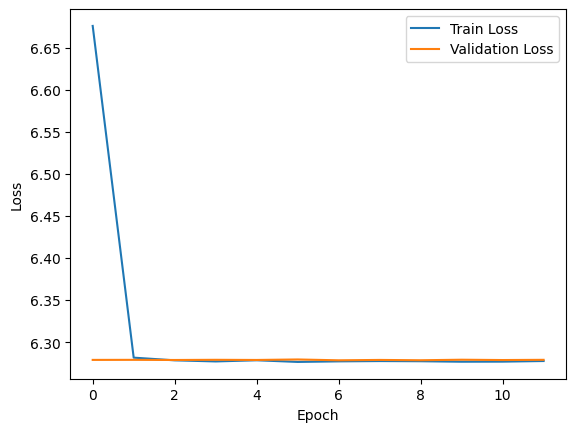

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('img.png')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(data["train_losses"])), data["train_losses"], label='Train Loss')
plt.plot(range(len(data["val_losses"])), data["val_losses"], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()